In [1]:
%load_ext rpy2.ipython

from fig_builder import (
    TwinsFiguresData,
    TwinsFigures,
    label_positions,
)

from plotnine import *
import pandas as pd
import warnings
from glob import glob
from os.path import isfile

warnings.filterwarnings('ignore')

fig_data = TwinsFiguresData()
figs = TwinsFigures(fig_data)
ORGANISM = 'Chryseobacterium_indoltheticum'
SPARSE_N = 100

In [2]:
raw_piles = figs.pileup(ORGANISM, sparse=SPARSE_N)
raw_piles

,pos,quality,read_count,read_results,ref_base,sample_name,seq
41,4400.0,NaN,1.00,NaN,NaN,011515_TW_B,NZ_FTMF01000027.1
141,4500.0,NaN,1.00,NaN,NaN,011515_TW_B,NZ_FTMF01000027.1
207,4800.0,NaN,1.60,NaN,NaN,011515_TW_B,NZ_FTMF01000027.1
307,4900.0,NaN,2.98,NaN,NaN,011515_TW_B,NZ_FTMF01000027.1
407,5000.0,NaN,1.39,NaN,NaN,011515_TW_B,NZ_FTMF01000027.1
...,...,...,...,...,...,...,...
14997,2684500.0,NaN,1.50,NaN,NaN,IIIF3SW_P,NZ_UFVS01000001.1
15182,2684700.0,NaN,2.10,NaN,NaN,IIIF3SW_P,NZ_UFVS01000001.1
15245,2685100.0,NaN,1.08,NaN,NaN,IIIF3SW_P,NZ_UFVS01000001.1
15393,2685300.0,NaN,1.00,NaN,NaN,IIIF3SW_P,NZ_UFVS01000001.1


In [3]:
piles = raw_piles.copy()
for col in ['time_label', 'subject', 'kind']:
    mycol = fig_data.metadata()[col]
    piles[col] = piles['sample_name'].map(lambda x: mycol.get(x, 'unknown'))

seqs = piles.query('subject == "TW"')['seq'].value_counts() > (1 * 1000 // SPARSE_N)
seqs = set(seqs[seqs].index)
piles = piles.query('seq in @seqs')

piles['time_label'] = pd.Categorical(
    piles['time_label'],
    categories=[
        'before',
        'flight',
        'after',
        'unknown',
    ],
    ordered=True,
)

def sum_pileup(tbl):
    #tbl = tbl.drop(columns=['read_results'])
    tbl = tbl.groupby(('seq', 'pos'), as_index=False).sum()
    return tbl

piles_condensed = piles.groupby(('time_label', 'subject', 'kind')).apply(sum_pileup)
piles_condensed = piles_condensed.reset_index(level=[0, 1, 2])
piles_condensed = piles_condensed.query('read_count > 1')

piles_condensed

,time_label,subject,kind,seq,pos,quality,read_count,read_results,ref_base
0,before,HR,buccal,NZ_CP033928.1,843500.0,0.0,1.34,0.0,0.0
1,before,HR,buccal,NZ_CP033928.1,843600.0,0.0,2.06,0.0,0.0
2,before,HR,buccal,NZ_CP033928.1,1183500.0,0.0,1.62,0.0,0.0
3,before,HR,buccal,NZ_CP033928.1,1183600.0,0.0,2.44,0.0,0.0
5,before,HR,buccal,NZ_CP033928.1,1184000.0,0.0,2.44,0.0,0.0
...,...,...,...,...,...,...,...,...,...
538,unknown,unknown,unknown,NZ_UFVS01000003.1,120000.0,0.0,1.03,0.0,0.0
539,unknown,unknown,unknown,NZ_UFVS01000003.1,120100.0,0.0,2.02,0.0,0.0
540,unknown,unknown,unknown,NZ_UFVS01000003.1,120200.0,0.0,1.69,0.0,0.0
541,unknown,unknown,unknown,NZ_UFVS01000003.1,120400.0,0.0,2.59,0.0,0.0


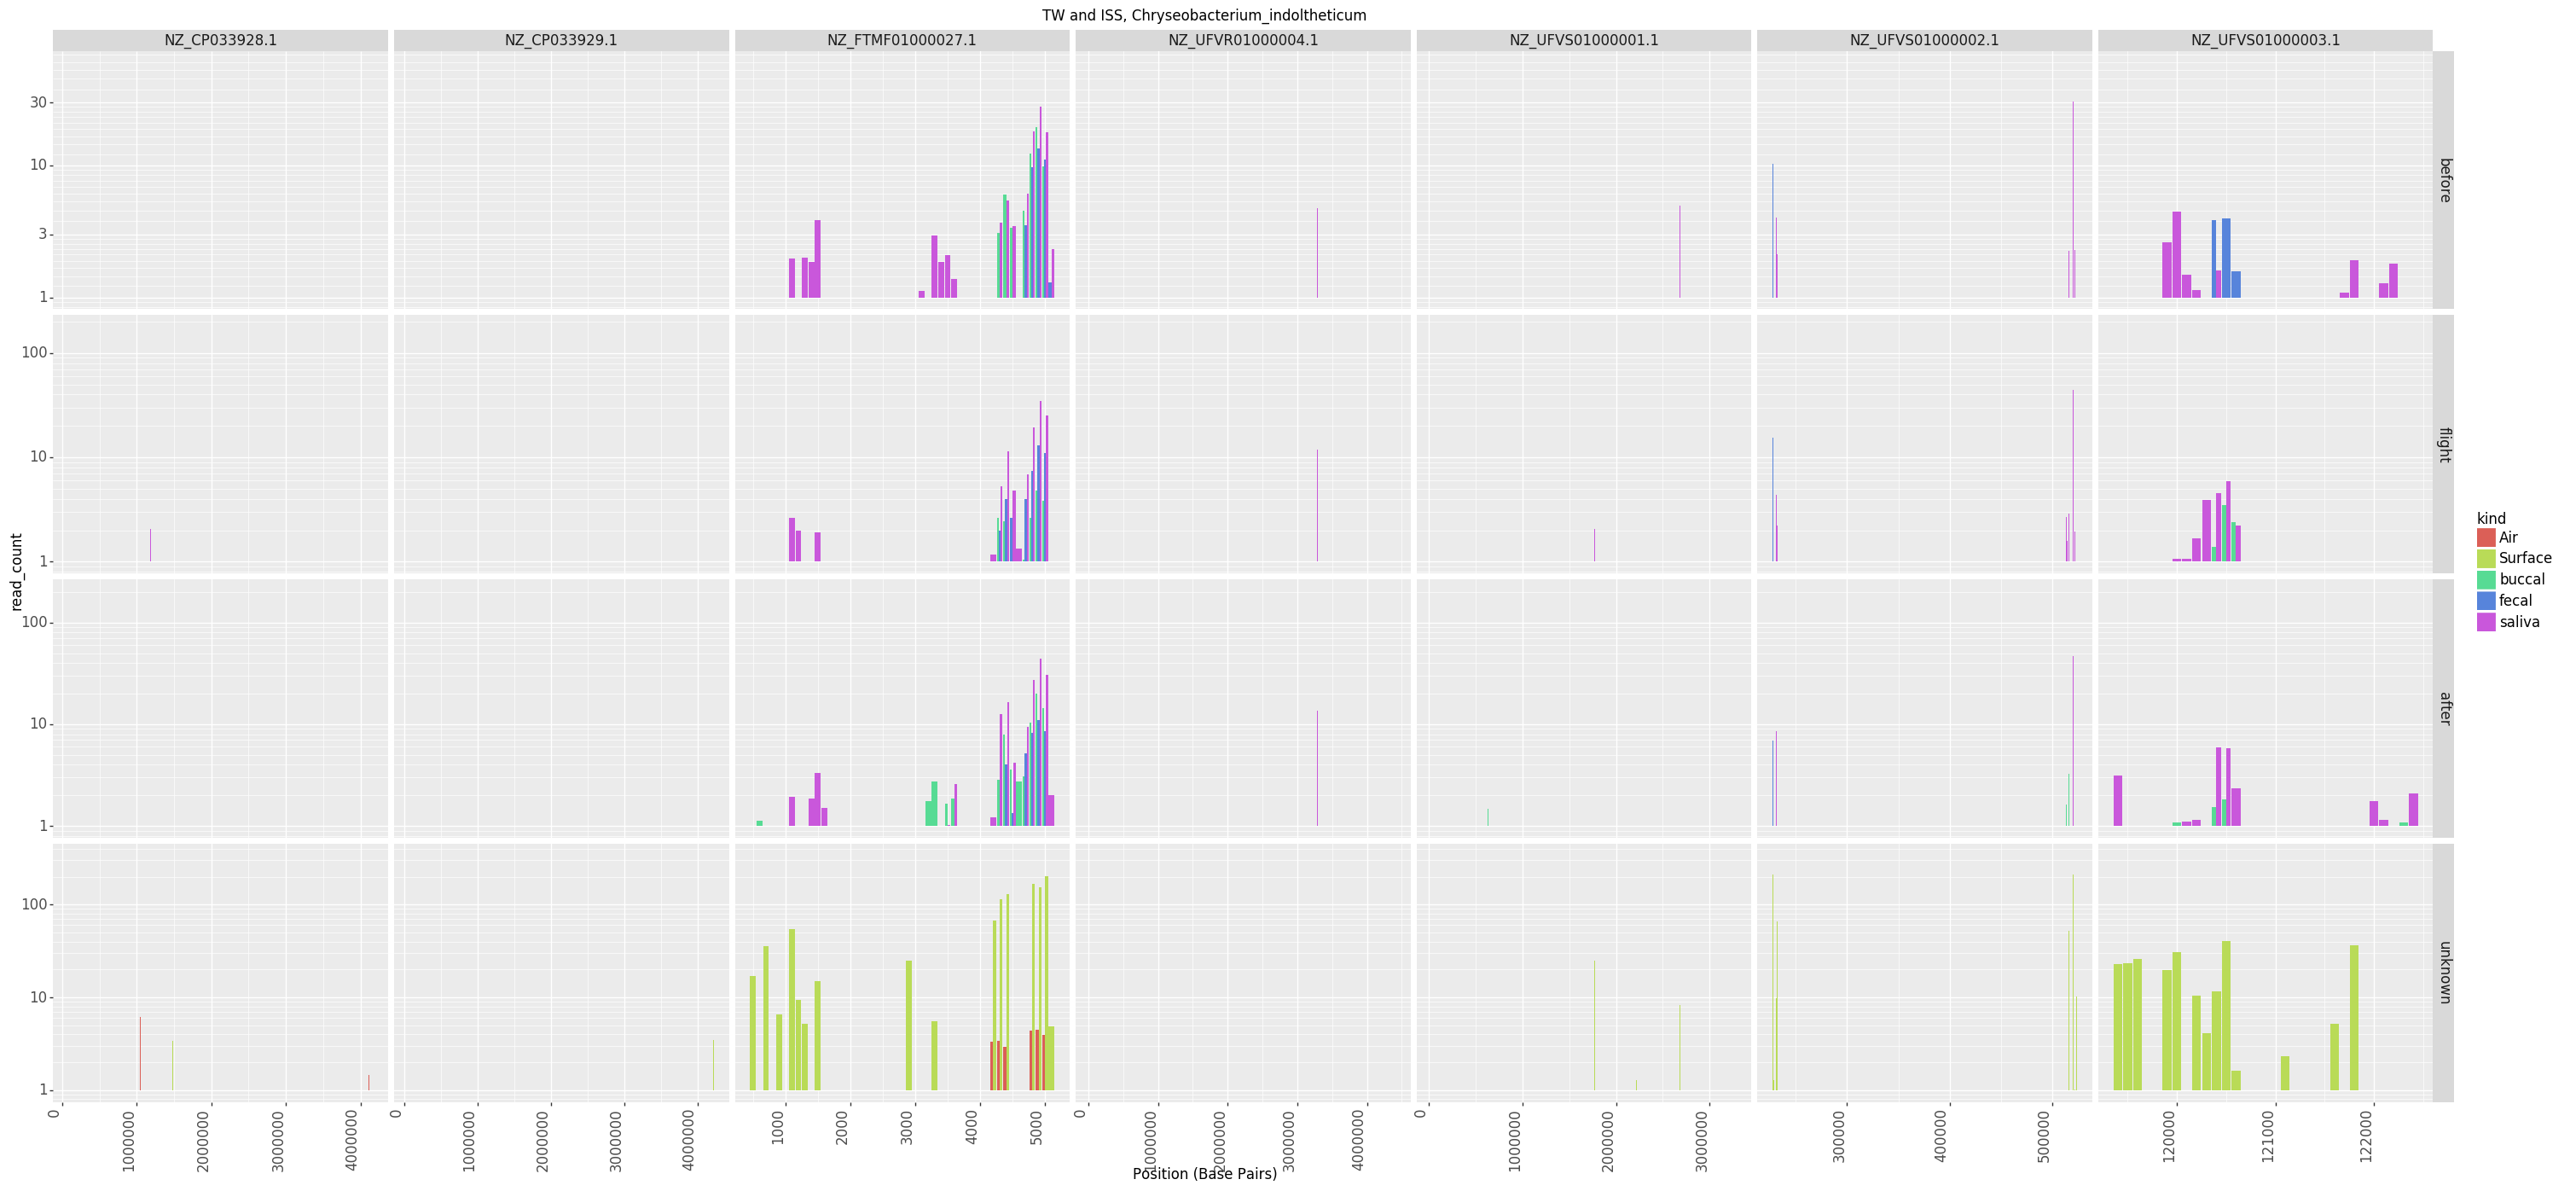

<ggplot: (8792082671736)>

In [4]:
subs = ['TW', 'ISS']
t = piles_condensed.query('subject in @subs')
(
    ggplot(t, aes(x='pos', y='read_count', fill='kind')) +
        facet_grid('time_label~seq', scales='free') +
        geom_col(position='dodge') +
        scale_y_log10() +
        ggtitle(f'TW and ISS, {ORGANISM}') +
        xlab(f'Position (Base Pairs)') +
        theme(
            text=element_text(size=12),
            axis_text_x=element_text(angle=90, hjust=1),
            figure_size=(36, 16),
            legend_position='right',
        )
)

In [5]:

label_positions(piles_condensed)

,subject,seq,position_label
pos,,,
